# Compute the hit-rates, paired-t-test stastics
- Analyze the hit rates of each class, using a 95% confidence interval. 
- Compare if the accuracy is significantly different from a random estimator by using a
  paired t-test statistic and a level of significance of p < 0.05

In [1]:
import io
import logging
import warnings
from typing import Any, Dict, Iterable, Iterator, List, Optional, Tuple, Union


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scps
import seaborn as sns
import sklearn.metrics as skm

import helpers.haws as haws
import helpers.hdbg as hdbg
import research_amp.soccer_prediction.utils as rasoprut

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [2]:
_LOG = logging.getLogger(__name__)

## Load the datasets

In [3]:
def get_predictions_data( 
                    bucket_name: str,
                    dataset_path: str,
                    ) -> Dict:
    """
    Download and load the GLM Poisson Regression Predictions data.
    
    :param bucket_name: S3 bucket name.
    :param dataset_path: Dataset path. 
    :return: dataset with predictions.
    """
        # Initialize a session.
    s3 = haws.get_service_resource(aws_profile="ck", service_name="s3")
    # Retrieve the CSV file from S3.
    obj = s3.Object(bucket_name, dataset_path)
    data = obj.get()["Body"].read().decode("utf-8")
    # Load the CSV file content into a pandas DataFrame.
    glm_predictions = pd.read_csv(io.StringIO(data))
    # Return the dataframe.
    return glm_predictions

def get_train_test_data( 
                    bucket_name: str,
                    dataset_path: str,
                    local_dir: str,
                    ) -> Dict:
    """
    Download and load the GLM Poisson Regression Predictions data.
    
    :param bucket_name: S3 bucket name.
    :param dataset_path: Dataset path. 
    :param local_dir: Local directory to store.
    :return: train_df and test_df.
    """
    # Download file from S3.
    rasoprut.download_data_from_s3(
                                bucket_name =bucket_name, 
                                dataset_path = dataset_path, 
                                local_path = local_dir, 
                                file_format = ".csv"
                                  )
    # Load the file content into a pandas DataFrame.
    dataframes = rasoprut.load_data_to_dataframe(
                                        local_path = local_dir,
                                        file_format = ".csv",
                                        sep = ",",
                                                )
    return dataframes

In [4]:
# Define the S3 location.
bucket_name = "cryptokaizen-data-test"
s3_file_path = "kaizen_ai/soccer_predictions/model_output/glm_predictions.csv" 
glm_predictions = get_predictions_data(bucket_name=bucket_name, dataset_path=s3_file_path)
# Fetch test and train data.
bucket_name = "cryptokaizen-data-test"
s3_path = "kaizen_ai/soccer_predictions/model_input/glm_poisson" 
local_dir = "datasets/model_input/glm_poisson"
dataframes = get_train_test_data(bucket_name = bucket_name, dataset_path = s3_path, local_dir=local_dir) 
# Access the test and train dataframes.
sampled_train_df = dataframes["sampled_train_df"]
train_df = dataframes["train_df"]
test_df = dataframes["test_df"]

## Generate Random predictions on test data.

In [5]:
def generate_random(df: pd.DataFrame()) -> pd.DataFrame():
    """
    Generates random match outcome. 
    
    :param df: Input dataframe with baseline predictions and probabilities.
    :return: Final dataframe with random and predicted outcomes.
    """
    # Generate random predictions for the naive classifier.
    np.random.seed(42)
    df["predicted_random"] = np.random.choice(
        ["home_win", "away_win", "draw"], size=len(df)
    )
    # Return the dataframe.
    return df

## Compute hit rate, confusion matrix and F1-score 

In [6]:
def compute_hit_rate(
                    df: pd.DataFrame(),
                    pred_column: str,
                    actual_column: str = "actual_outcome", 
                    ) -> Dict:
    """
    Compute the hit rates for each class.
    
    :param df: df containing soccer match data and predictions.
    :return: Hit rates dictionary.
    """
    # Check if the provided columns exist.
    hdbg.dassert_in(pred_column, 
                    df.columns, 
                    f"The DataFrame does not contain the given columns: {pred_column}")
    hdbg.dassert_in(actual_column, 
                    df.columns, 
                    f"The DataFrame does not contain the given columns: {actual_column}")
    classes = ['home_win', 'draw', 'away_win']
    hit_rates = {}
    # Compute hit rates for each class.
    for cls in classes:
        hits = np.sum((df[actual_column] == cls) & (df[pred_column] == cls))
        total = np.sum(df[actual_column] == cls)
        hit_rate = hits / total if total > 0 else 0
        ci = scps.norm.ppf(0.975) * np.sqrt((hit_rate * (1 - hit_rate)) / total) if total > 0 else 0
        hit_rates[cls] = {
            'hit_rate': hit_rate,
            'confidence_interval': (hit_rate - ci, hit_rate + ci)
        }
    # Compute overall hit rate.
    overall_hits = np.sum(df[actual_column] == df[pred_column])
    overall_total = len(df)
    overall_hit_rate = overall_hits / overall_total
    overall_ci = scps.norm.ppf(0.975) * np.sqrt((overall_hit_rate * (1 - overall_hit_rate)) / overall_total)
    hit_rates['overall'] = {
        'hit_rate': overall_hit_rate,
        'confidence_interval': (overall_hit_rate - overall_ci, overall_hit_rate + overall_ci)
    }
    # Return hit rates for each class and overall.
    return hit_rates


def compute_confusion_matrix_and_f1(
                                df: pd.DataFrame(),
                                pred_column: str,
                                actual_column: str = "actual_outcome"
                                ) -> Dict:
    """
    Compute the confusion matrix and f1 scores.
    
    :param df: df containing soccer match data and predictions.
    return: 
    """
    # Check if the provided columns exist.
    hdbg.dassert_in(pred_column, 
                    df.columns, 
                    f"The DataFrame does not contain the given columns: {pred_column}")
    hdbg.dassert_in(actual_column, 
                    df.columns, 
                    f"The DataFrame does not contain the given columns: {actual_column}")
    y_true = df[actual_column]
    y_pred = df[pred_column]
    # Compute confusion matrix.
    conf_matrix = skm.confusion_matrix(y_true, y_pred, labels=['home_win', 'draw', 'away_win'])
    # Compute F1 scores for each class.
    f1_scores = skm.f1_score(y_true, y_pred, labels=['home_win', 'draw', 'away_win'], average=None)
    # Compute macro F1 score.
    f1_score_macro = skm.f1_score(y_true, y_pred, labels=['home_win', 'draw', 'away_win'], average='macro')
    # Compute overall F1 score.
    f1_score_overall = skm.f1_score(y_true, y_pred, average='weighted')
    results = {
        'confusion_matrix': conf_matrix,
        'f1_scores': {
            'home_win': f1_scores[0],
            'draw': f1_scores[1],
            'away_win': f1_scores[2],
            'macro': f1_score_macro,
            'overall': f1_score_overall
        }
    }
    return results

def visualize_results(glm_predictions: pd.DataFrame, hit_rate_poisson: Dict, hit_rate_random: Dict):
    # Bar graph for predicted outcome, predicted random, and actual outcome
    plt.figure(figsize=(12, 6))
    sns.countplot(data=glm_predictions, 
                  x='actual_outcome',
                  color='blue', 
                  label='Actual Outcome', 
                  alpha=0.5)
    sns.countplot(data=glm_predictions, 
                  x='predicted_outcome', 
                  color='orange', 
                  label='Predicted Outcome', 
                  alpha=0.5)
    sns.countplot(data=glm_predictions, 
                  x='predicted_random', 
                  color='green', 
                  label='Predicted Random', 
                  alpha=0.5)
    plt.title('Distribution of Outcomes')
    plt.xlabel('Outcome')
    plt.ylabel('Count')
    plt.legend()
    plt.show()
    
    # Accuracy bar graph for predicted outcome and predicted random
    accuracies = {
        'Predicted Outcome': np.mean(glm_predictions['predicted_outcome'] == glm_predictions['actual_outcome']),
        'Predicted Random': np.mean(glm_predictions['predicted_random'] == glm_predictions['actual_outcome'])
    }
    plt.figure(figsize=(8, 6))
    plt.bar(accuracies.keys(), accuracies.values(), color=['orange', 'green'])
    plt.title('Accuracy of Predicted Outcome and Predicted Random')
    plt.ylabel('Accuracy')
    plt.show()
    # Hit rate bar graph.
    hit_rate_poisson_values = [v['hit_rate'] for v in hit_rate_poisson.values()]
    hit_rate_random_values = [v['hit_rate'] for v in hit_rate_random.values()]
    labels = hit_rate_poisson.keys()
    x = np.arange(len(labels))
    plt.figure(figsize=(12, 6))
    plt.bar(x - 0.2, hit_rate_poisson_values, width=0.4, label='Poisson', color='orange')
    plt.bar(x + 0.2, hit_rate_random_values, width=0.4, label='Random', color='green')
    plt.xticks(x, labels)
    plt.title('Hit Rates for Poisson and Random Predictions')
    plt.ylabel('Hit Rate')
    plt.legend()
    plt.show()

def get_datasets() -> Tuple:
    """
    Create all the required datasets.
    """
    bucket_name = "cryptokaizen-data-test"
    s3_file_path = "kaizen_ai/soccer_predictions/model_output/glm_predictions.csv" 
    glm_predictions = get_predictions_data(bucket_name=bucket_name, dataset_path=s3_file_path)
    # Fetch test and train data.
    bucket_name = "cryptokaizen-data-test"
    s3_path = "kaizen_ai/soccer_predictions/model_input/glm_poisson" 
    local_dir = "datasets/model_input/glm_poisson"
    dataframes = get_train_test_data(bucket_name = bucket_name, dataset_path = s3_path, local_dir=local_dir) 
    # Access the test and train dataframes.
    sampled_train_df = dataframes["sampled_train_df"]
    train_df = dataframes["train_df"]
    test_df = dataframes["test_df"]
    return train_df, test_df, glm_predictions

## Analysis of the data.

In [7]:
def analyze_data(df: pd.DataFrame()) -> None:
    """
    Perform anaylsis using the functions. 
    
    :param df: Input dataframe with the necessary columns.
    """
    # Generate Random Predictions for test data. 
    final_df = generate_random(glm_predictions)
    # Compute hit rates for test data.
    hit_rate_poisson = compute_hit_rate(glm_predictions, "predicted_outcome")
    hit_rate_random = compute_hit_rate(glm_predictions, "predicted_random")
    print("\n\n\n\n\nHit Rate Analysis for Poisson Model.")
    print(hit_rate_poisson)
    print("\n\n\n\n\nHit Rate Analysis for Naive Model.")
    print(hit_rate_random)
    # Compute confusion matrix and f1 scores.
    results_poisson = compute_confusion_matrix_and_f1(glm_predictions, "predicted_outcome")
    results_random = compute_confusion_matrix_and_f1(glm_predictions, "predicted_random")
    print("\n\n\n\n\nConfusion Matrix Analysis for Poisson Model.")
    print(results_poisson)
    print("\n\n\n\n\nConfusion Matrix Analysis for Naive Model.")
    print(results_random)
    # Visualize the data.
    visualize_results(glm_predictions, hit_rate_poisson, hit_rate_random)






Hit Rate Analysis for Poisson Model.
{'home_win': {'hit_rate': 0.7998032904148784, 'confidence_interval': (0.7923872929502755, 0.8072192878794813)}, 'draw': {'hit_rate': 0.0, 'confidence_interval': (0.0, 0.0)}, 'away_win': {'hit_rate': 0.39469128678592036, 'confidence_interval': (0.38318497742849966, 0.40619759614334106)}, 'overall': {'hit_rate': 0.4717499293243407, 'confidence_interval': (0.46553208700018683, 0.4779677716484945)}}





Hit Rate Analysis for Naive Model.
{'home_win': {'hit_rate': 0.33467453505007155, 'confidence_interval': (0.3259291704696226, 0.3434198996305205)}, 'draw': {'hit_rate': 0.3235515425131678, 'confidence_interval': (0.3123031699839756, 0.33479991504236)}, 'away_win': {'hit_rate': 0.327466820542412, 'confidence_interval': (0.3164194397710215, 0.3385142013138025)}, 'overall': {'hit_rate': 0.32967166107992407, 'confidence_interval': (0.32381636852450385, 0.3355269536353443)}}





Confusion Matrix Analysis for Poisson Model.
{'confusion_matrix': array([[

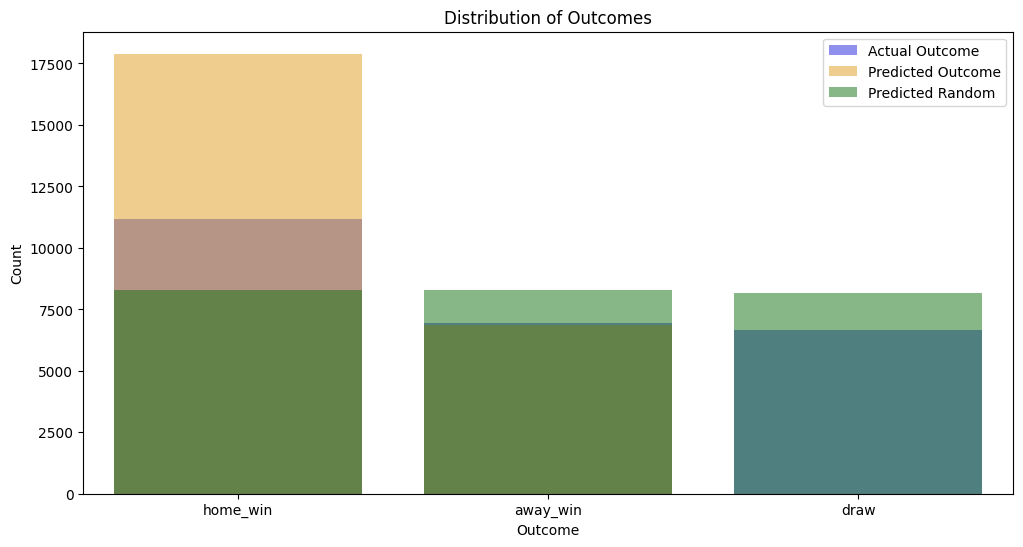

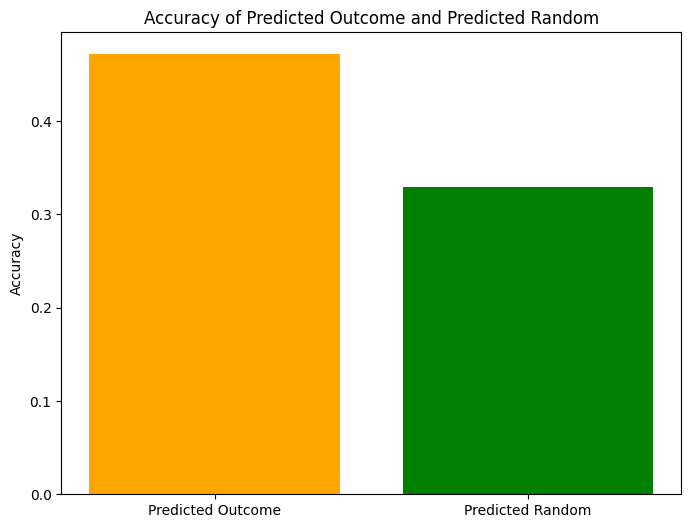

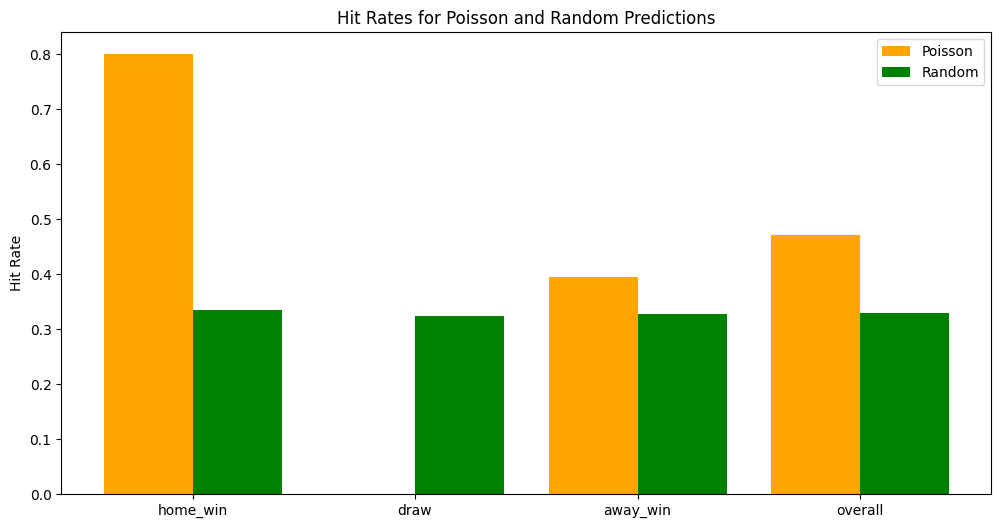

In [8]:
analyze_data(glm_predictions)

## Paired t-test hypothesis testing.

In [9]:
def compute_accuracy(df: pd.DataFrame, column: str) -> float:
    """
    Compute the accuracy for the given column.
    
    :param df: DataFrame containing the actual and predicted outcomes.
    :param column: Column name for predicted outcomes.
    :return: Accuracy.
    """
    accuracy = np.mean(df[column] == df['actual_outcome'])
    return accuracy

def sample_and_compute_accuracy(
                                df: pd.DataFrame, 
                                column: str, 
                                n_samples: int = 7000,
                                logging_level: int = logging.INFO,
                               ) -> float:
    """
    Sample n_samples rows from the DataFrame and compute accuracy for the given column.
    
    :param df: DataFrame containing the actual and predicted outcomes.
    :param column: Column name for predicted outcomes.
    :param n_samples: Number of rows to sample.
    :return: Accuracy.
    """
    sample_df = df.sample(n=n_samples, random_state=np.random.randint(0, 10000))
    return compute_accuracy(sample_df, column)

def perform_t_test(
                   poisson_accuracies: List[float], 
                   random_accuracies: List[float],
                   logging_level: int = logging.INFO) -> None:
    """
    Perform a t-test on the accuracy values.
    
    :param poisson_accuracies: List of accuracies for the Poisson model.
    :param random_accuracies: List of accuracies for the random method.
    """
    t_stat, p_value = scps.ttest_ind(poisson_accuracies, random_accuracies)
    print(f"T-test result: t-statistic = {t_stat}, p-value = {p_value}")
    if p_value < 0.05:
        print(f"The difference in accuracy is significant (p < 0.05) because p_value = {p_value}")
    else:
        print(f"The difference in accuracy is not significant (p >= 0.05) because p_value = {p_value}")

        
def perform_model_hypothesis(test_df: pd.DataFrame) -> None:
    """
    Perform hypothesis testing and visualize the results (model-level).
    
    :param df: Input dataframe.
    """
    # Repeat the sampling and accuracy calculation 100 times.
    poisson_accuracies = []
    random_accuracies = []
    for _ in range(100):
        poisson_acc = sample_and_compute_accuracy(test_df, "predicted_outcome")
        random_acc = sample_and_compute_accuracy(test_df, "predicted_random")
        poisson_accuracies.append(poisson_acc)
        random_accuracies.append(random_acc)
    # Perform the t-test.
    perform_t_test(poisson_accuracies, random_accuracies)
    # Visualize the accuracy results.
    plt.figure(figsize=(10, 6))
    plt.hist(poisson_accuracies, bins=20, alpha=0.7, label='Poisson Accuracy')
    plt.hist(random_accuracies, bins=20, alpha=0.7, label='Random Accuracy')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.title('Distribution of Accuracies')
    plt.legend()
    plt.show()

T-test result: t-statistic = 197.86678654938177, p-value = 1.6798531024023402e-229
The difference in accuracy is significant (p < 0.05) because p_value = 1.6798531024023402e-229


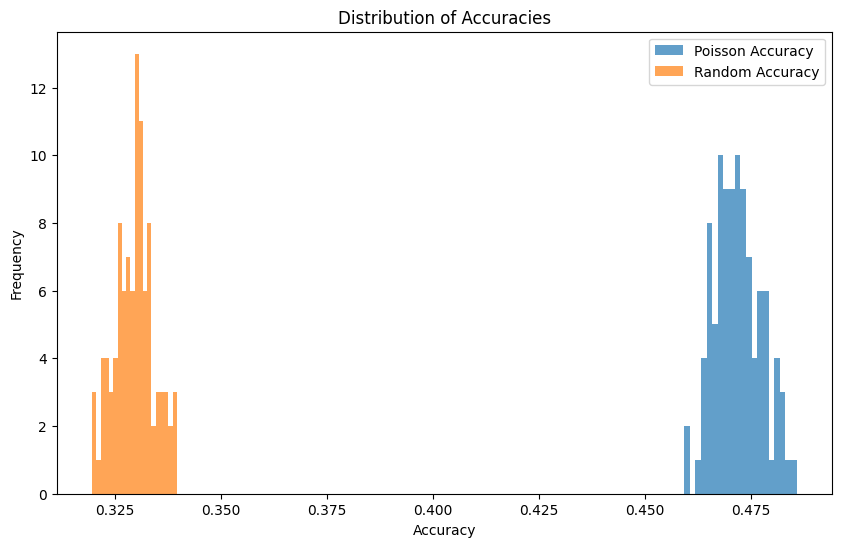

In [10]:
perform_model_hypothesis(glm_predictions)

### Class wise distribution.

In [11]:
# Define helper functions.
def compute_class_accuracy(df: pd.DataFrame, column: str, outcome_class: str) -> float:
    """
    Compute the accuracy for a specific outcome class.
    
    :param df: DataFrame containing the actual and predicted outcomes.
    :param column: Column name for predicted outcomes.
    :param outcome_class: Specific class to compute accuracy for.
    :return: Accuracy.
    """
    class_df = df[df['actual_outcome'] == outcome_class]
    accuracy = np.mean(class_df[column] == class_df['actual_outcome'])
    return accuracy

def sample_and_compute_class_accuracies(df: pd.DataFrame, column: str, n_samples: int = 7000) -> Dict[str, float]:
    """
    Sample n_samples rows from the DataFrame and compute accuracy for each class.
    
    :param df: DataFrame containing the actual and predicted outcomes.
    :param column: Column name for predicted outcomes.
    :param n_samples: Number of rows to sample.
    :return: Dictionary with accuracies for each class.
    """
    sample_df = df.sample(n=n_samples, random_state=np.random.randint(0, 10000))
    classes = ['home_win', 'draw', 'away_win']
    accuracies = {cls: compute_class_accuracy(sample_df, column, cls) for cls in classes}
    return accuracies

def perform_t_test_and_collect_stats(poisson_accuracies: List[Dict[str, float]], random_accuracies: List[Dict[str, float]]) -> Dict[str, Dict[str, float]]:
    """
    Perform t-tests on the accuracy values for individual classes and collect t-test statistics.
    
    :param poisson_accuracies: List of accuracies for the Poisson model.
    :param random_accuracies: List of accuracies for the random method.
    :return: Dictionary with t-test statistics for each class.
    """
    classes = ['home_win', 'draw', 'away_win']
    t_test_stats = {}

    for cls in classes:
        poisson_acc_class = [acc[cls] for acc in poisson_accuracies]
        random_acc_class = [acc[cls] for acc in random_accuracies]
        t_stat, p_value = scps.ttest_ind(poisson_acc_class, random_acc_class)
        t_test_stats[cls] = {
            't_statistic': t_stat,
            'p_value': p_value
        }
        print(f"T-test result for {cls}: t-statistic = {t_stat}, p-value = {p_value}")
        if p_value < 0.05:
            print(f"The difference in accuracy for {cls} is significant (p < 0.05).")
        else:
            print(f"The difference in accuracy for {cls} is not significant (p >= 0.05).")
    
    return t_test_stats


def perform_class_hypothesis(test_df: pd.DataFrame()) -> None:
    """
    Visualize the t-test statistics for Poisson and random predictions for each class.
    
    :param df: Input Dataframe.
    """
    # Repeat the sampling and accuracy calculation 100 times.
    poisson_accuracies = []
    random_accuracies = []
    for _ in range(100):
        poisson_acc = sample_and_compute_class_accuracies(test_df, "predicted_outcome")
        random_acc = sample_and_compute_class_accuracies(test_df, "predicted_random")
        poisson_accuracies.append(poisson_acc)
        random_accuracies.append(random_acc)
    # Perform the t-test and collect statistics.
    t_test_stats = perform_t_test_and_collect_stats(poisson_accuracies, random_accuracies)
    classes = ['home_win', 'draw', 'away_win']
    t_stats = [t_test_stats[cls]['t_statistic'] for cls in classes]
    p_values = [t_test_stats[cls]['p_value'] for cls in classes]
    plt.figure(figsize=(12, 6))
    # Plot t-statistics
    plt.subplot(1, 1, 1)
    plt.bar(classes, t_stats, color=['blue', 'orange', 'green'])
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Class')
    plt.ylabel('T-statistic')
    plt.title('T-statistics for Different Classes')

T-test result for home_win: t-statistic = 513.6633405460507, p-value = 2.3793832509127e-311
The difference in accuracy for home_win is significant (p < 0.05).
T-test result for draw: t-statistic = -358.4468225406554, p-value = 1.9095891594613706e-280
The difference in accuracy for draw is significant (p < 0.05).
T-test result for away_win: t-statistic = 49.559733870447495, p-value = 1.481403600127772e-113
The difference in accuracy for away_win is significant (p < 0.05).


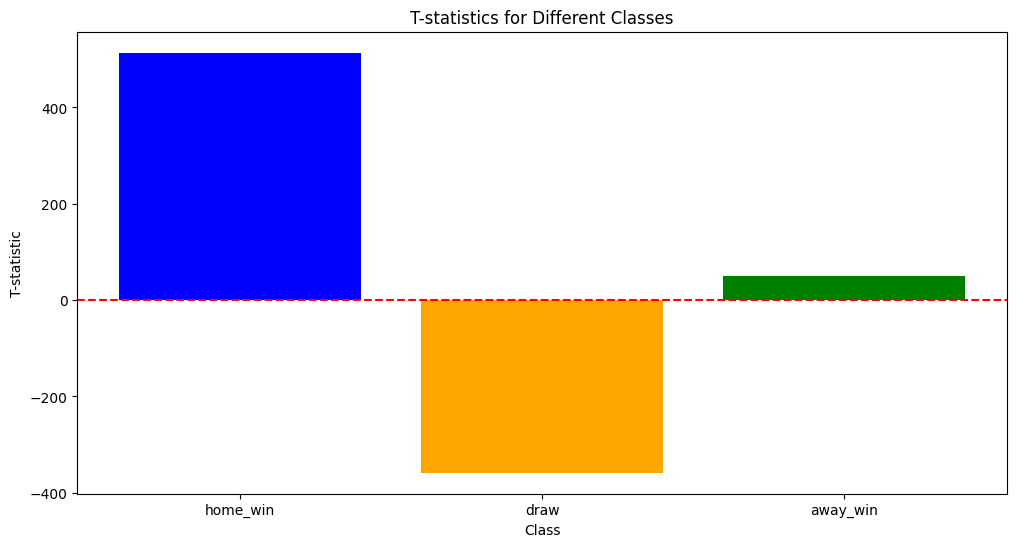

In [12]:
perform_class_hypothesis(glm_predictions)